This notebook is used to study a given input dataset, its dirty variant and the resulting imputed version.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os.path as osp
from scipy.stats import entropy

import utils_stats as utils

from importlib import reload
reload(utils)

<module 'utils_stats' from '/home/spoutnik23/PycharmProjects/GRIMP/utils_stats.py'>

In [47]:
clean_dataset_path = 'data/embdi-study/imdb_movielens-master.csv'
df_orig = pd.read_csv(clean_dataset_path)
df_orig.describe(include='object')

,actor_1,actor_2,actor_3,color,content_rating,director,genres,original_language,production_companies,production_countries,status,title
count,47488,46166,45256,4529,4529,49027,42963,49862,33522,43666,45266,49840
unique,19000,23411,25890,2,15,17688,20,126,10518,199,6,42210
top,robert_de_niro,morgan_freeman,donald_pleasence,color,r,woody_allen,drama,en,paramount_pictures,us,released,cinderella
freq,104,39,25,4344,2060,71,11948,32185,996,18410,44907,12


# Clean dataframe

### Data types
Numeric columns are problematic to impute, especially if they contain real numbers (rather than simple integers).
Here we are looking for those columns, to know what to impute and how.

In [48]:
df_orig.select_dtypes(include='number')

,release_date_rounded,vote_average,year
0,NaN,8.0,2009.0
1,NaN,7.0,2007.0
2,NaN,7.0,2015.0
3,NaN,8.0,2012.0
4,NaN,7.0,2012.0
...,...,...,...
49870,199105.0,6.0,1991.0
49871,201111.0,9.0,2011.0
49872,200308.0,4.0,2003.0
49873,191710.0,0.0,1917.0


In [49]:
df_orig = df_orig.convert_dtypes()
df_orig.dtypes

actor_1                 string
actor_2                 string
actor_3                 string
color                   string
content_rating          string
director                string
genres                  string
original_language       string
production_companies    string
production_countries    string
release_date_rounded     Int64
status                  string
title                   string
vote_average             Int64
year                     Int64
dtype: object

In [32]:
bname = osp.basename(clean_dataset_path)
base, ext = osp.splitext(clean_dataset_path)
fname = base + '_dtypes.txt'
with open(fname, 'w') as fp:
    fp.write(bname + '\n')
    for idx, val in df_orig.dtypes.iteritems():
        s = f'{idx}\t{val}\n'
        fp.write(s)

### Frequency of values
Here we are measuring the average frequency of each unique value in the dataset, as well as the distribution of values
by quantiles.

Knowing the distribution in quantiles would give us an idea of which values to drop from the graph because they're too
rare to contribute to the imputation, and might instead add noise to the training.

In [50]:
col_counts = dict()
for col in df_orig.columns:
    col_counts[col] = df_orig[col].value_counts()
    k,v = col, col_counts[col]
    print(f'{k:<20}{len(v):>5}{len(df_orig)/len(v):>10.2f}')

print('Measuring overall frequency of values')
counts = Counter(df_orig.values.ravel())
cc = pd.Series(counts)
print(f'20% quantile: {cc.quantile(.2)}')
print(f'50% quantile: {cc.quantile(.5)}')
print(f'80% quantile: {cc.quantile(.8)}')
print(f'90% quantile: {cc.quantile(.9)}')

avg_redundancy = cc.mean()
print(f'Average redundancy over the full dataset: {avg_redundancy:.2f}')

avg_lt5 = []
for col in col_counts:
    avg_red = col_counts[col].mean()
    if avg_red < 5:
        avg_lt5.append(col)
    print(f'{col}: {avg_red:.2f}')

actor_1             19000      2.62
actor_2             23411      2.13
actor_3             25890      1.93
color                   2  24937.50
content_rating         15   3325.00
director            17688      2.82
genres                 20   2493.75
original_language     126    395.83
production_companies10518      4.74
production_countries  199    250.63
release_date_rounded 1350     36.94
status                  6   8312.50
title               42210      1.18
vote_average           11   4534.09
year                  135    369.44
Measuring overall frequency of values
20% quantile: 1.0
50% quantile: 1.0
80% quantile: 2.0
90% quantile: 4.0
Average redundancy over the full dataset: 6.30
actor_1: 2.50
actor_2: 1.97
actor_3: 1.75
color: 2264.50
content_rating: 301.93
director: 2.77
genres: 2148.15
original_language: 395.73
production_companies: 3.19
production_countries: 219.43
release_date_rounded: 33.59
status: 7544.33
title: 1.18
vote_average: 4534.09
year: 369.44


In [51]:
col_counts_norm = dict()
for col in df_orig.columns:
    col_counts_norm[col] = df_orig[col].value_counts(normalize=True, sort=False)
    k,v = col, col_counts_norm[col]

In [52]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

In [57]:
print(f'{"Column name":<20}: {"Entropy":>8} {"Variance":>8} {"Avg red":>8} {"Distinct":>8}')
for col in col_counts_norm:
    col_entropy = entropy(list(col_counts_norm[col]))/len(col_counts[col])
    col_variance = np.std(col_counts[col])
    avg_red = col_counts[col].mean()
    gm = geo_mean([col_entropy, avg_red])
    print(f'{col:<20}: {col_entropy:8.5f} {col_variance:>8.2f} {avg_red:>8.2f} {len(col_counts[col]):>8}')

Column name         :  Entropy Variance  Avg red Distinct
actor_1             :  0.00048     4.63     2.50    19000
actor_2             :  0.00041     2.37     1.97    23411
actor_3             :  0.00038     1.76     1.75    25890
color               :  0.08531  2079.50  2264.50        2
content_rating      :  0.09108   597.15   301.93       15
director            :  0.00052     4.29     2.77    17688
genres              :  0.11625  2996.52  2148.15       20
original_language   :  0.01322  2885.10   395.73      126
production_companies:  0.00074    20.73     3.19    10518
production_countries:  0.01311  1364.19   219.43      199
release_date_rounded:  0.00491    42.02    33.59     1350
status              :  0.00894 16709.28  7544.33        6
title               :  0.00025     0.50     1.18    42210
vote_average        :  0.15994  5321.04  4534.09       11
year                :  0.03082   512.41   369.44      135


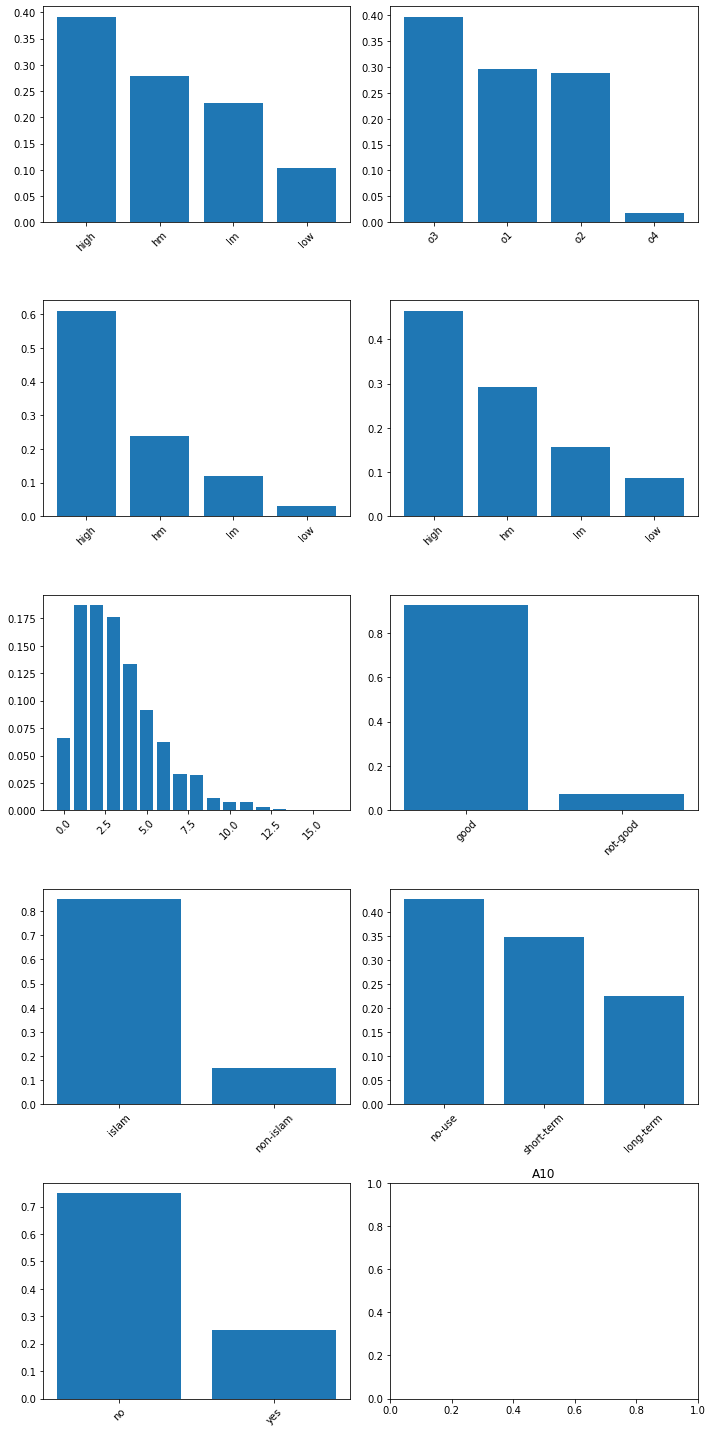

In [34]:
# Saving only columns with < 50 distinct values for clarity.
plot_cols = [col for col in df_orig.columns if len(col_counts[col]) < 20]
_t = len(plot_cols)//2+len(plot_cols)%2
fig, axs = plt.subplots(ncols=2, nrows=_t, figsize=(10,20))
for idx, col in enumerate(plot_cols):
    x = idx%_t
    y = idx//_t
    axs[x,y].bar(col_counts[col].index, col_counts[col]/len(df_orig))
    # _ = axs[x,y].xticks(rotation='vertical',)
    axs[x,y].tick_params(axis='x', rotation=45)
    plt.title(col)
fig.tight_layout()

In [7]:
qfrac = 0.9
frequent_values = dict()
rare_values = dict()
for col in col_counts:
    print(col)
    vc = col_counts[col]
    up_qle = vc.quantile(qfrac)
    low_qle = vc.quantile(1-qfrac)

    frequent_values[col] = vc[vc>up_qle].index.tolist()
    rare_values[col] = vc[vc<low_qle].index.tolist()

    print(f'{qfrac*100}% Quantile: {up_qle:.0f}')
    print(vc[vc>up_qle])
    print(sum(vc[vc>up_qle])/sum(vc))
    print()

id
90.0% Quantile: 1
Series([], Name: id, dtype: Int64)
0.0

bike_name
90.0% Quantile: 49
bajaj_pulsar_150cc_dtsi                   527
bajaj_pulsar_180cc_dtsi                   177
bajaj_pulsar_220f_dtsi                    144
honda_unicorn_alloy                       143
yamaha_yzf_r15_version_2.0                141
hero_honda_karizma_r                      110
bajaj_avenger_220                         108
bajaj_pulsar_200_ns                       100
tvs_apache_rtr_160                         99
hero_honda_cbz_xtreme_self_start           95
yamaha_fz16                                92
bajaj_pulsar_135                           89
royal_enfield_thunderbird_350              82
hero_honda_passion_pro                     79
royal_enfield_bullet_350                   76
hero_honda_passion_plus                    72
bajaj_discover_100                         71
honda_stunner_cbf_self_disc_alloy          71
yamaha_fz_s                                64
yamaha_rx_135_std                   

In [41]:
# pd.pivot_table(df_orig, index='A1', columns='A2', aggfunc='count')
contingency = pd.crosstab(df_orig['A1'], df_orig['A2'])
from scipy.stats import chi2_contingency
c, p, dof, exp = chi2_contingency(contingency.transpose())
p

3.711031038569636e-07

In [43]:
pd.DataFrame(index=df_orig.columns, columns=df_orig.columns)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


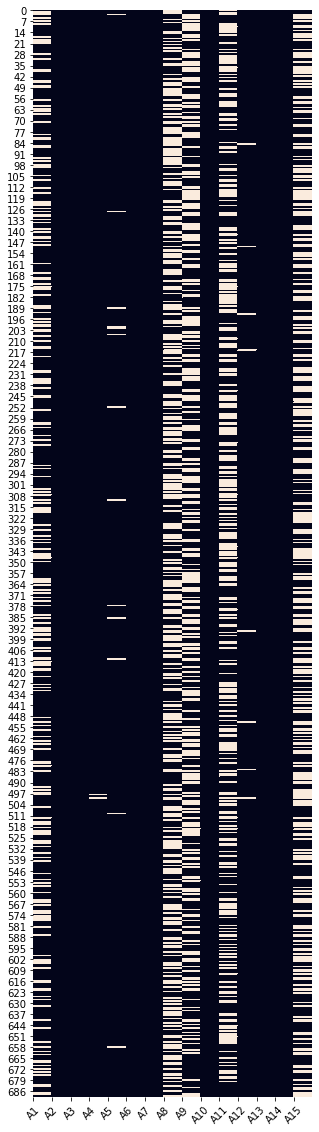

In [22]:
df_rares = df_orig.copy()
for col in df_rares:
    df_rares[col] = df_orig[col].isin(rare_values[col])
plt.figure(figsize=(5, 20))
sns.heatmap(df_rares.values, cbar=False)
_ = plt.xticks(ticks=np.arange(len(df_orig.columns)), labels=df_orig.columns, rotation=45)

In [23]:
rare_count  = 0
tot_count = 0
for col in rare_values:
    rare_count += sum(col_counts[col].loc[rare_values[col]])
    tot_count += sum(col_counts[col])
print(f'Rare values fraction: {rare_count / tot_count*100:.2f}%')

Rare values fraction: 14.42%


# Dirty dataframe

In [8]:
dirty_dataset_path = 'data/new-hard_dirty/bikes-dekho_all_columns_2.csv'
df_dirty = pd.read_csv(dirty_dataset_path)

In [9]:
# Make sure that the datasets have the same shape
assert df_orig.shape == df_dirty.shape

In [10]:
nulls = pd.isna(df_dirty)
target_columns = df_orig.columns[nulls.sum(axis=0)>0]

In [20]:
pd.isna(df_dirty).sum().sum()/(df_dirty.shape[0]*df_dirty.shape[1])
# nulls.sum(axis=1).mean()

0.020058503969912243

### Compare with clean

In [12]:
print('Unique values by column')
col_counts_d = dict()
for col in df_dirty.columns:
    col_counts_d[col] = df_dirty[col].value_counts()
    k,v = col, col_counts_d[col]


_tmp = {
'clean':    {k: len(v) for k, v in col_counts.items()},
'dirty':    {k: len(v) for k, v in col_counts_d.items()}
}
counts_df = pd.DataFrame.from_records(data=_tmp, columns=['clean', 'dirty'])
counts_df['diff'] = counts_df['dirty'] - counts_df['clean']
counts_df

Unique values by column


,clean,dirty,diff
id,4786,4690,-96
bike_name,274,273,-1
city_posted,3,3,0
km_driven,570,560,-10
color,45,45,0
fuel_type,4,4,0
price,303,300,-3
model_year,35,35,0
owner_type,6,6,0


### Values impossible to impute


In [14]:
impossible = {k: None for k in target_columns}
affected_rows = {k: 0 for k in target_columns}
for col in target_columns:
    unq_dirty = df_dirty[col].unique()
    unq_clean = df_orig[col].unique()
    impossible[col] = [_ for _ in unq_clean if _ not in unq_dirty]
    # if len(impossible[col]) > 0:
    #     print('\n'.join([str(_) for _ in impossible[col]]))
    affected_rows[col] = len(df_orig[col].loc[df_orig[col].isin(impossible[col])])
    print(f'Column {col} has affected rows = {affected_rows[col]}')

Column id has affected rows = 96
Column bike_name has affected rows = 2
Column city_posted has affected rows = 0
Column km_driven has affected rows = 10
Column color has affected rows = 0
Column fuel_type has affected rows = 0
Column price has affected rows = 3
Column model_year has affected rows = 0
Column owner_type has affected rows = 0


In [15]:
print('Distribution of values over the entire dataset compared to missing values. ')
for col in target_columns:
    df_orig[col].loc[nulls[col]].value_counts()
    _tmp = {
        'Full dataset': col_counts[col]/len(df_orig),
        'Dirty rows': df_orig[col].loc[nulls[col]].value_counts()/sum(nulls[col])
    }
    cdf = pd.DataFrame.from_records(data=_tmp, columns=['Full dataset', 'Dirty rows']).sort_values('Full dataset', ascending=False)
    print()
    print(col)
    print(cdf)


Distribution of values over the entire dataset compared to missing values. 

id
       Full dataset  Dirty rows
36082      0.000209        <NA>
44571      0.000209        <NA>
44569      0.000209        <NA>
44567      0.000209        <NA>
44565      0.000209        <NA>
...             ...         ...
40139      0.000209        <NA>
40138      0.000209        <NA>
40117      0.000209        <NA>
40116      0.000209        <NA>
48770      0.000209        <NA>

[4786 rows x 2 columns]

bike_name
                             Full dataset  Dirty rows
bajaj_pulsar_150cc_dtsi          0.110113    0.114583
bajaj_pulsar_180cc_dtsi          0.036983    0.052083
bajaj_pulsar_220f_dtsi           0.030088        <NA>
honda_unicorn_alloy              0.029879    0.052083
yamaha_yzf_r15_version_2.0       0.029461    0.041667
...                                   ...         ...
honda_cbr_250r_abs_tricolor      0.000209        <NA>
honda_cbr_250r_std_tricolor      0.000209        <NA>
suzuki_zeus_12

# Imputed dataframe

In [629]:
imputed_dataset_path = 'results/imputed_datasets/contraceptive_all_columns_40_imputed.csv'
df_imp = pd.read_csv(imputed_dataset_path)

In [630]:
# Undo refactoring of strings

def clean_str(val):
    if val != val:
        # value is nan
        return ''
    else:
        return str(val).split('_', maxsplit=1)[1]

for i, col in enumerate(df_imp.columns):
    print(col)
    df_imp[col] = df_imp[col].apply(clean_str)

df_imp.to_csv('results/imputed_datasets/contraceptive_all_columns_40_imputed_c.csv', index=False)
# df_imp = df_imp.convert_dtypes()

A1
A2
A3
A4
A5
A6
A7
A8
A9
A10


In [615]:
correct_imputations = {k:None for k in target_columns}
incorrect_imputations = {k:None for k in target_columns}
for col in correct_imputations:
    imputations = df_imp[col].loc[nulls[col]]
    v_correct = (df_imp[col].loc[nulls[col]] == df_orig.loc[nulls[col], col])
    v_incorrect = (df_imp[col].loc[nulls[col]] != df_orig.loc[nulls[col], col])

    correct_imputations[col] = imputations[v_correct].index
    incorrect_imputations[col] = imputations[v_incorrect].index
    count_clean = df_orig.loc[v_correct.index].value_counts(col)
    count_dirty = df_orig.iloc[incorrect_imputations[col]].value_counts(col)
    frac_wrong = count_dirty/count_clean
    dd = pd.DataFrame(columns=['total', 'wrong', 'ratio'])
    dd['total'] = count_clean
    dd['wrong'] = count_dirty
    dd['ratio'] = frac_wrong
    print(dd)

    total  wrong  ratio
A1                     
25     33     33    1.0
32     33     33    1.0
30     32     32    1.0
26     28     28    1.0
28     27     27    1.0
21     26     26    1.0
35     25     25    1.0
29     25     25    1.0
38     24     24    1.0
33     24     24    1.0
47     24     24    1.0
45     22     22    1.0
36     22     22    1.0
22     21     21    1.0
27     20     20    1.0
23     18     18    1.0
24     16     16    1.0
34     16     16    1.0
20     15     15    1.0
43     15     15    1.0
41     14     14    1.0
31     14     14    1.0
39     13     13    1.0
37     12     12    1.0
42     12     12    1.0
49     11     11    1.0
40      9      9    1.0
44      8      8    1.0
19      8      8    1.0
48      8      8    1.0
46      7      7    1.0
18      3      3    1.0
17      2      2    1.0
16      2      2    1.0
      total  wrong     ratio
A2                          
high    236     34  0.144068
hm      153     30  0.196078
lm      129     29  

In [609]:
col = 'marital-status'
i1 = set(df_orig.loc[incorrect_imputations[col]].index)
i2 = set(df_orig.loc[df_orig[col].isin(frequent_values[col])].index)
i1i2 = list(i1.intersection(i2))
display(df_imp.iloc[i1i2])
display(df_orig.iloc[i1i2])

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([1476, 1480, 1485, 1486, 1494,\n            ...\n            2974, 2979, 2988, 2990, 3004],\n           dtype='int64', length=254). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [610]:
imputed_dataset_path = 'results/imputed_datasets/adult_nonulls_sample10_marital-status_20_imputed.csv'
df_imp = pd.read_csv(imputed_dataset_path)
_ = utils.incorrect_imputations(df_imp, df_orig, target_columns, nulls)

KeyError: 'A1'

In [626]:
misses_col = nulls.sum()
for col in correct_imputations:
    n_in = len(correct_imputations[col])
    print(n_in/misses_col[col])

0.0
0.8098471986417657
0.8030560271646859
0.0
0.8505942275042445
0.9762308998302207
0.7911714770797963
0.7232597623089984
0.9185059422750425
0.6791171477079796


In [623]:
misses_col[col]

589